In [158]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import matplotlib.animation as animation
from tqdm import tqdm
import matplotlib.patches as mpatch
plt.rc('animation', html='html5')
plt.rcParams["animation.embed_limit"] = 500

In [2]:
df = pd.read_csv("output\German1\DATA_SMOOTH_TRAJECTORIES.csv",names=["time","traj_id","x","y"], delimiter="\t")

In [3]:
list_of_trajid = df.groupby(by=["time"]).traj_id.agg([list,"count"]) #generating the list of traj_ids that is presented in each timeframe

In [4]:
list_of_trajid_gt_1 = list_of_trajid[list_of_trajid["count"]>1] #getting the trajid list which is greater then 1

In [5]:
traj_ids_unique = [list(d) for d in list(set(list_of_trajid_gt_1.list.apply(lambda list_of_trajid_gt_1: tuple(list_of_trajid_gt_1))))]

In [6]:
selected_idx = np.random.choice(np.arange(0,len(traj_ids_unique)), 20)

In [7]:
selected_trajids = [traj_ids_unique[x] for x in selected_idx]

In [8]:
selected_trajids

[[4583, 3353, 9844],
 [15200, 5789],
 [1247, 8089, 13823],
 [1478, 16186, 15477, 11505],
 [12160, 12291],
 [12936, 8013, 3949, 12386],
 [2820, 10322, 13078],
 [675, 11728, 15751],
 [737, 6578],
 [11615, 3584],
 [9406, 11257],
 [3126, 11918, 5924, 10881, 14414, 14938, 1581],
 [6296, 6864],
 [5911, 9047],
 [14814, 5434],
 [13221, 6480, 7636],
 [14208, 9502, 13420],
 [12625, 13506, 5389],
 [4247, 14370, 2903, 15468],
 [5779, 12541]]

In [9]:
bg_store_img_metadata = {'path':"./data/german_1/storePlan_fix.jpg",'image_crop':[0, 45.6, 0, 26.7], "x_lim": (-1, 44.56), "y_lim" : (26.40, -1) }
def putBgStoreImage(ax, plotFunc = None):
    bg_img = mpimg.imread(bg_store_img_metadata["path"])
    
    ax.xaxis.tick_top()

    ax.imshow(bg_img, extent=bg_store_img_metadata["image_crop"], origin="lower", aspect="equal")

    ax.set_xlim(bg_store_img_metadata["x_lim"])
    ax.set_ylim(bg_store_img_metadata["y_lim"])

In [168]:
def getTrajectory(traj_data):
    traj_data = traj_data.sort_values(by="time")
    
    fig,ax = plt.subplots(figsize=(12,6))
    putBgStoreImage(ax)

    legends_patches = []

    colors = ["b", "r", "c", "g", "m", "y", "k", "w", "tab:blue", "tab:orange", "tab:green", "tab:red", 
              "tab:purple", "tab:brown", "tab:pink", "tab:gray", "tab:olive", "tab:cyan", "gold", "lime"]
    
    for idx, uniqueId in enumerate(traj_data.traj_id.unique(),0):
        traj_data_partial = traj_data[traj_data.traj_id == uniqueId]

        start = traj_data_partial.iloc[0]
        end = traj_data_partial.iloc[-1]

        legends_patches.append(mpatch.Patch(color=colors[idx], label=f"{uniqueId}"))

        square, = ax.plot(traj_data_partial.x, traj_data_partial.y, color = colors[idx], marker = 's', markersize=3 )
        ax.plot(traj_data_partial['x'], traj_data_partial['y'], color = colors[idx],  markersize=0.5) 
    
        circle_start = plt.Circle((start["x"],start["y"]), 0.5, color="green")
        circle_end = plt.Circle((end["x"],end["y"]), 0.5, color="yellow")

        ax.add_patch(circle_start)
        ax.add_patch(circle_end)
    
    ax.set_title(f'Trajectory for tag {traj_data.traj_id.unique()}')

    str_trajids = map(lambda x: str(x), traj_data.traj_id.unique())

    trajids = "_".join(str_trajids)

    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

    plt.legend(handles=legends_patches, loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)

    plt.savefig(f'output/multiagentAnalysisOutput/{trajids}.png')
    plt.show()

In [177]:
def trajectoryAnimation(traj_data):
    traj_data = traj_data.sort_values(by="time")
    
    fig, ax = plt.subplots(figsize=(12,6))
    putBgStoreImage(ax)

    colors = ["b", "r", "c", "g", "m", "y", "k", "w", "tab:blue", "tab:orange", "tab:green", "tab:red", 
              "tab:purple", "tab:brown", "tab:pink", "tab:gray", "tab:olive", "tab:cyan", "gold", "lime"]
    
    unique_ids = list(traj_data.traj_id.unique())
    unique_ids_len = len(unique_ids)
    
    traj_dict = {
        "line":[],
        "dot":[],
        "square":[],
        "data":[[[ [] for _ in range(2)] for _ in range(3)] for _ in range(unique_ids_len)]
    }

    traj_data_grouped = traj_data.groupby(by="time").agg(list)

    legends_patches = []

    for idx,traj_id in enumerate(unique_ids):
        square, = ax.plot([], [], color = 'blue', marker = 's', markersize=2 )
        line, = ax.plot([], [], color = 'grey' )
        dot, = ax.plot([], [], color = 'black', marker = 'o' )
        traj_dict["square"].append(square)
        traj_dict["line"].append(line)
        traj_dict["dot"].append(dot)

        legends_patches.append(mpatch.Patch(color=colors[idx],label=f"{traj_id}"))

        traj_dict["data"][idx][2][0].append(-1 * np.inf)
        traj_dict["data"][idx][2][1].append(-1 * np.inf)
    
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
    
    
        
    def update_frame(t):
        group = traj_data_grouped.iloc[t]

        for idx in range(len(group["traj_id"])):
            traj_idx = unique_ids.index(group["traj_id"][idx])
            traj_dict["data"][traj_idx][0][0].append(group["x"][idx])
            traj_dict["data"][traj_idx][0][1].append(group["y"][idx])

            traj_dict["data"][traj_idx][1][0].append(group["x"][idx])
            traj_dict["data"][traj_idx][1][1].append(group["y"][idx])

            traj_dict["data"][traj_idx][2][0].append(group["x"][idx])
            traj_dict["data"][traj_idx][2][1].append(group["y"][idx])

        ax.clear()

        putBgStoreImage(ax)

        for idx in range(unique_ids_len):
            ax.plot(traj_dict["data"][idx][0][0],traj_dict["data"][idx][0][1], marker="s", markersize=3, color=colors[idx])
            ax.plot(traj_dict["data"][idx][1][0],traj_dict["data"][idx][1][1],color=colors[idx],markersize=2)
            ax.plot(traj_dict["data"][idx][2][0][-1],traj_dict["data"][idx][2][1][-1],color=colors[idx],markersize=6, marker="o")
            
        ax.set_title(f'Relationship between x and y at step {t}', fontsize=14)
        

        ax.legend(handles=legends_patches, loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)


    
    time = np.arange(traj_data_grouped.shape[0])
    anim = animation.FuncAnimation(fig, update_frame, frames=time, interval=100)

    str_trajids = map(lambda x: str(x), unique_ids)

    trajids = "_".join(str_trajids)

    anim.save(f'output/multiagentAnalysisOutput/{trajids}.gif', writer='pillow')
    plt.close()
    return anim

  0%|          | 0/20 [00:00<?, ?it/s]

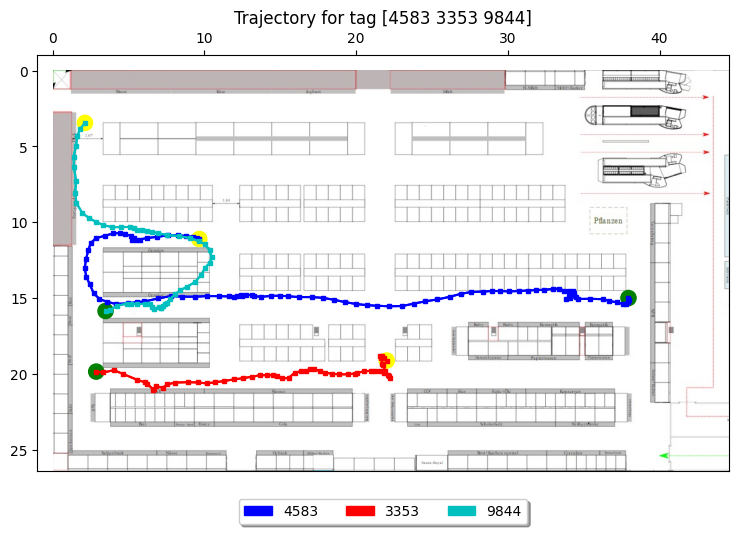

  5%|▌         | 1/20 [01:09<22:09, 69.97s/it]

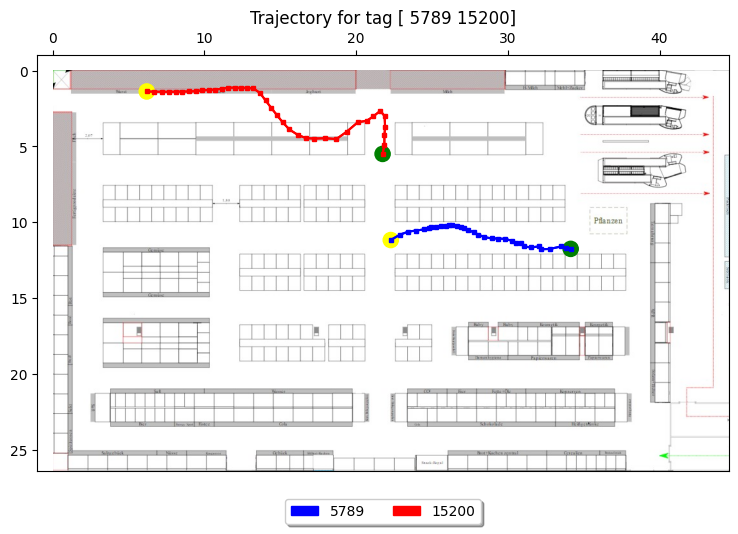

 10%|█         | 2/20 [01:54<16:32, 55.16s/it]

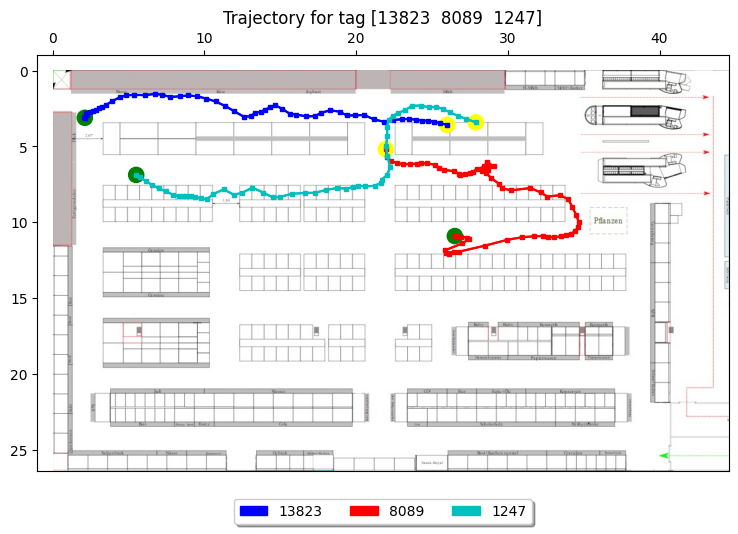

 15%|█▌        | 3/20 [02:44<14:56, 52.74s/it]

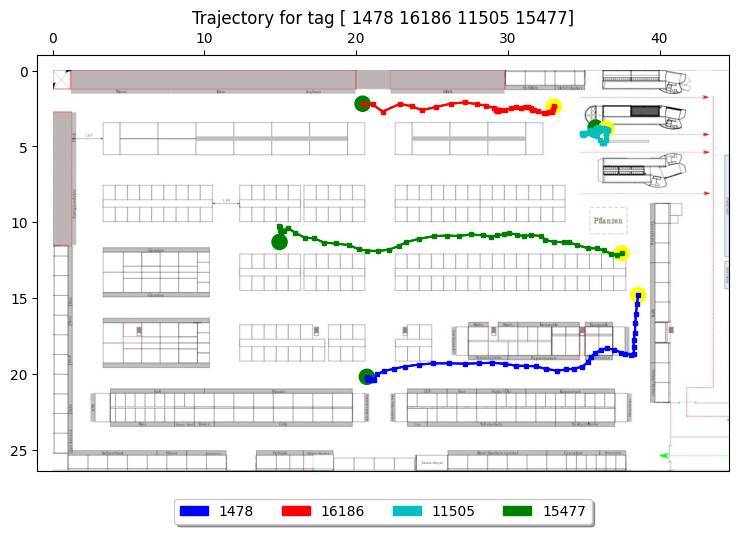

 20%|██        | 4/20 [03:36<13:59, 52.47s/it]

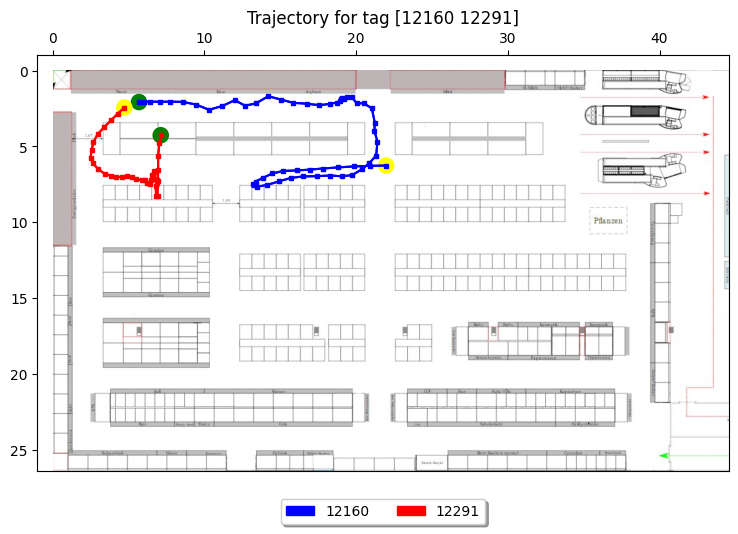

 25%|██▌       | 5/20 [04:13<11:44, 46.97s/it]

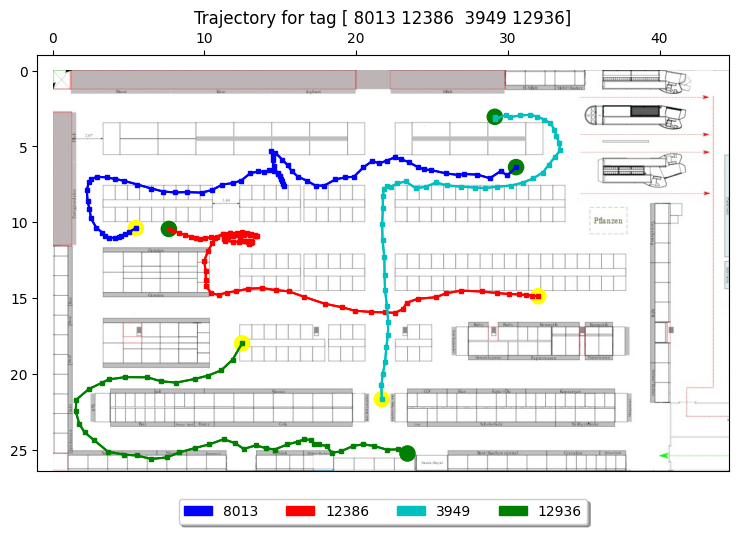

 30%|███       | 6/20 [05:11<11:47, 50.57s/it]

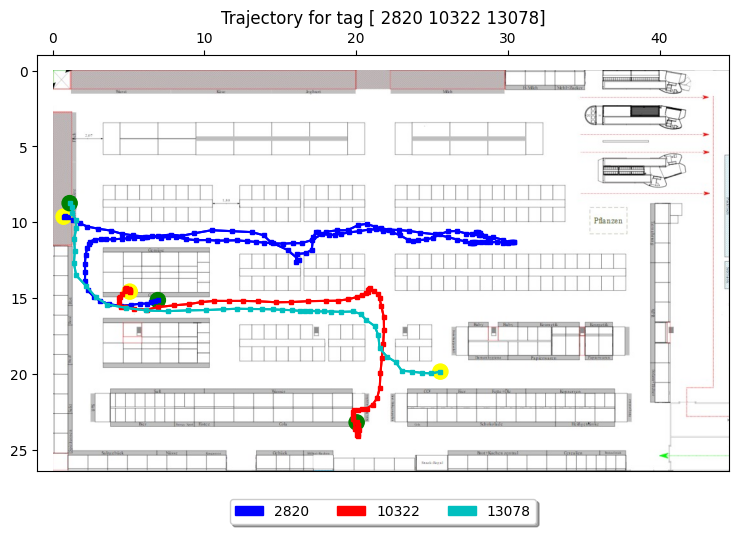

 35%|███▌      | 7/20 [07:00<15:05, 69.65s/it]

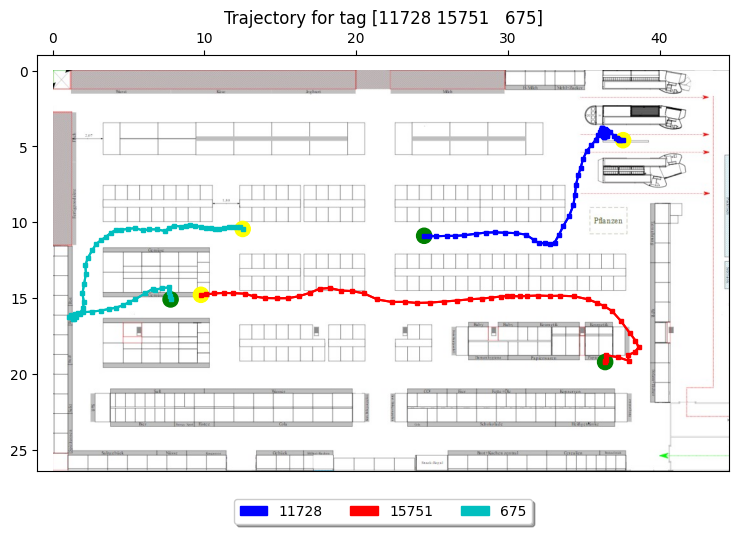

 40%|████      | 8/20 [07:56<13:05, 65.48s/it]

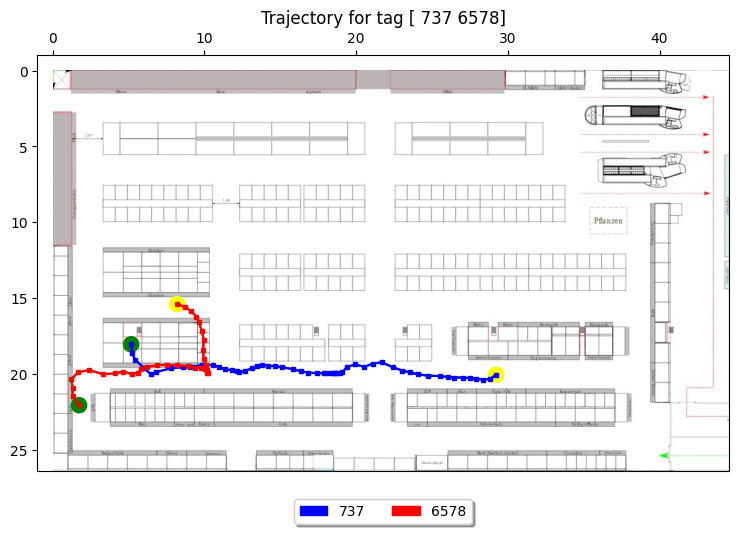

 45%|████▌     | 9/20 [08:31<10:15, 55.92s/it]

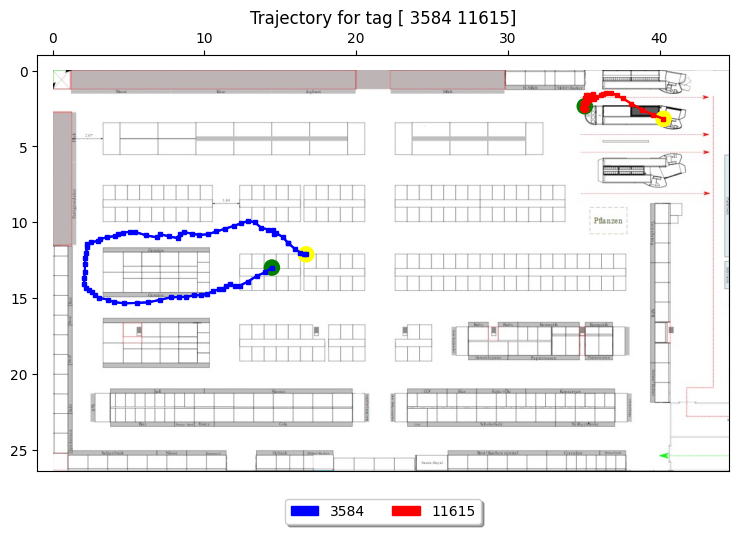

 50%|█████     | 10/20 [09:17<08:48, 52.86s/it]

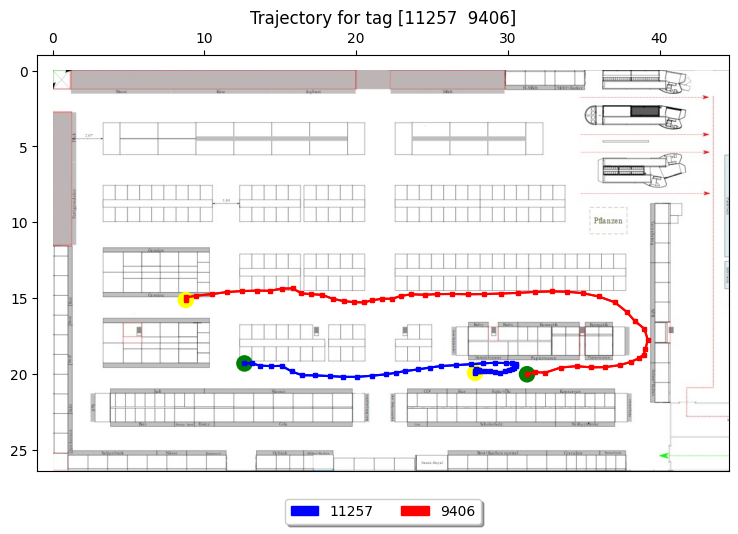

 55%|█████▌    | 11/20 [10:13<08:04, 53.85s/it]

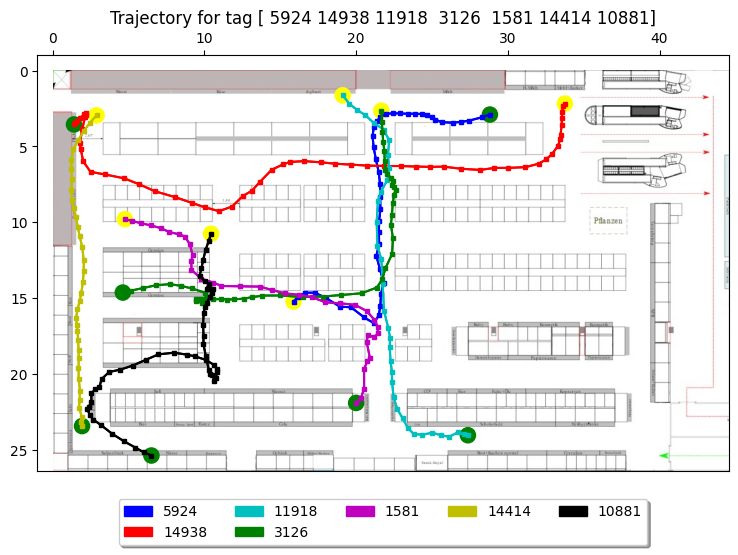

 60%|██████    | 12/20 [11:24<07:50, 58.86s/it]

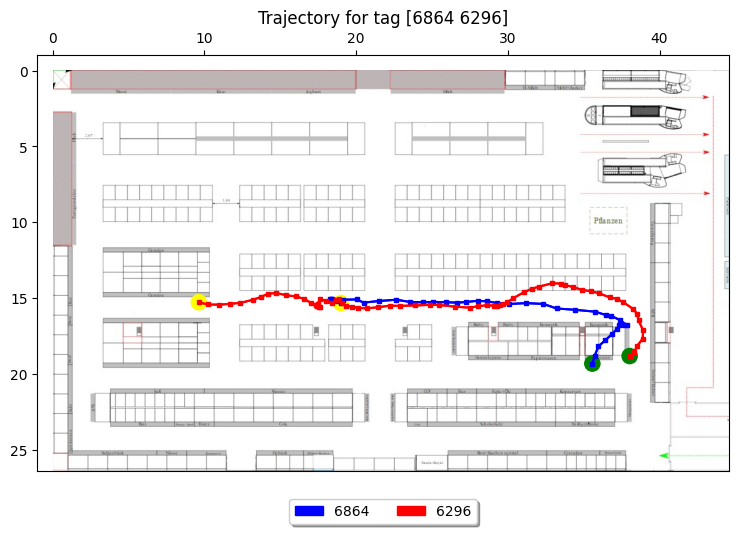

 65%|██████▌   | 13/20 [12:33<07:14, 62.09s/it]

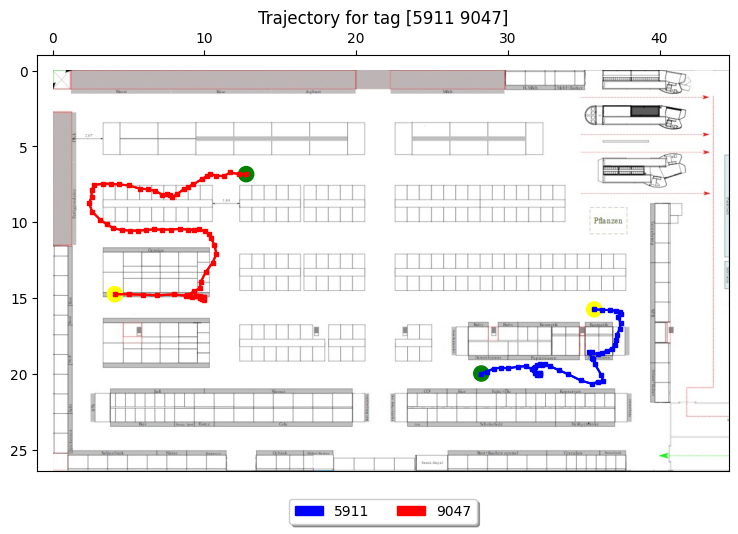

 70%|███████   | 14/20 [13:33<06:08, 61.49s/it]

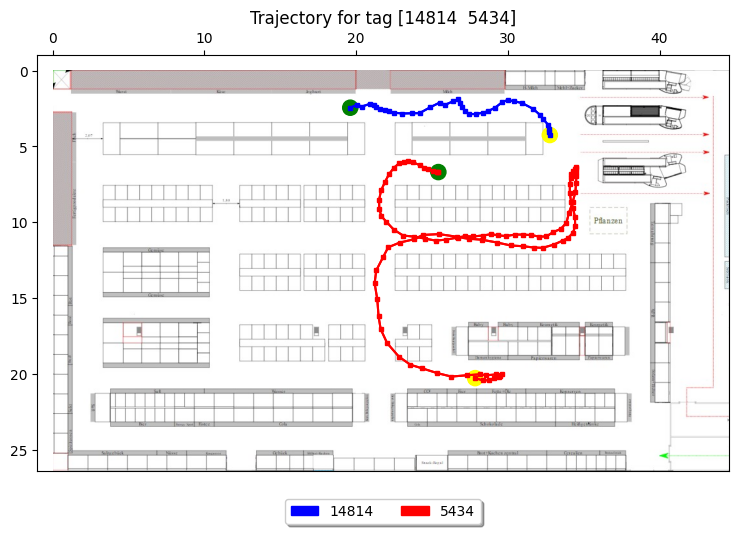

 75%|███████▌  | 15/20 [14:41<05:16, 63.22s/it]

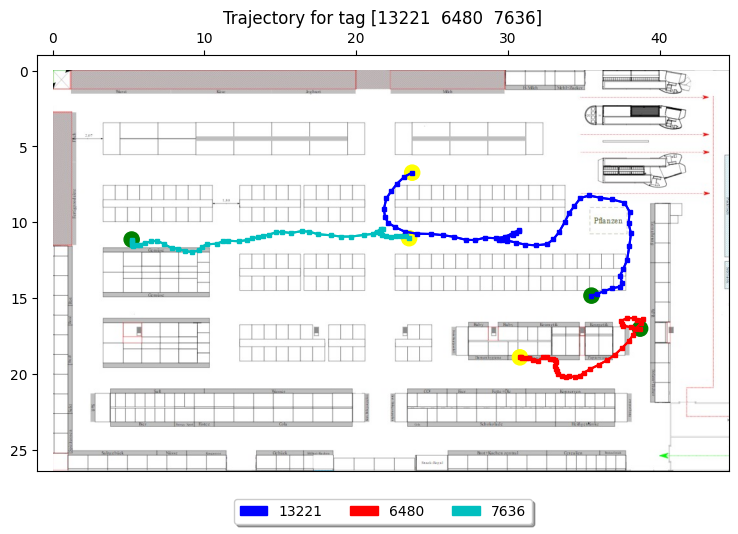

 80%|████████  | 16/20 [15:37<04:04, 61.25s/it]

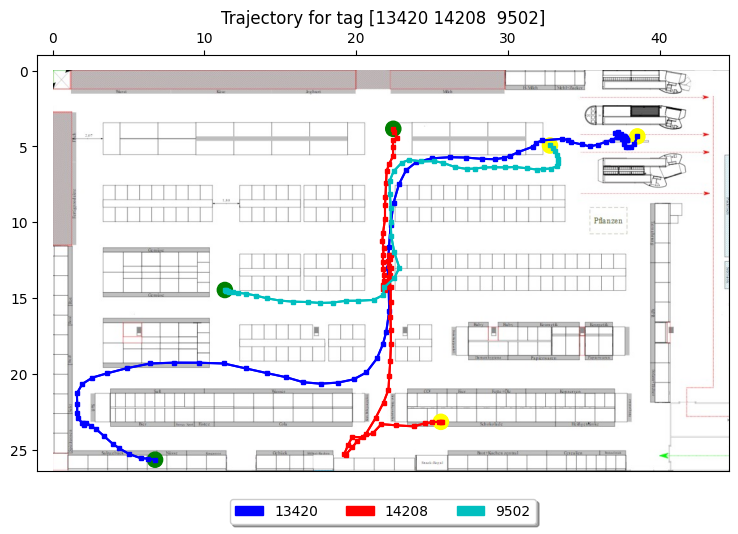

 85%|████████▌ | 17/20 [16:54<03:17, 65.75s/it]

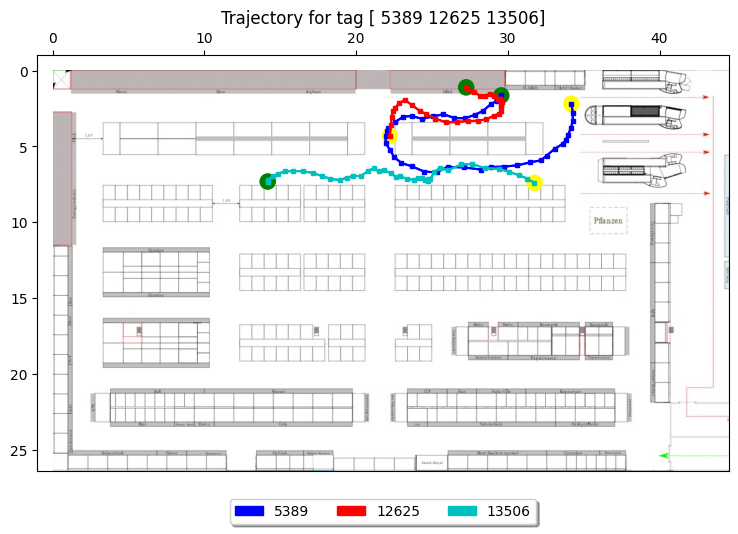

 90%|█████████ | 18/20 [17:38<01:58, 59.24s/it]

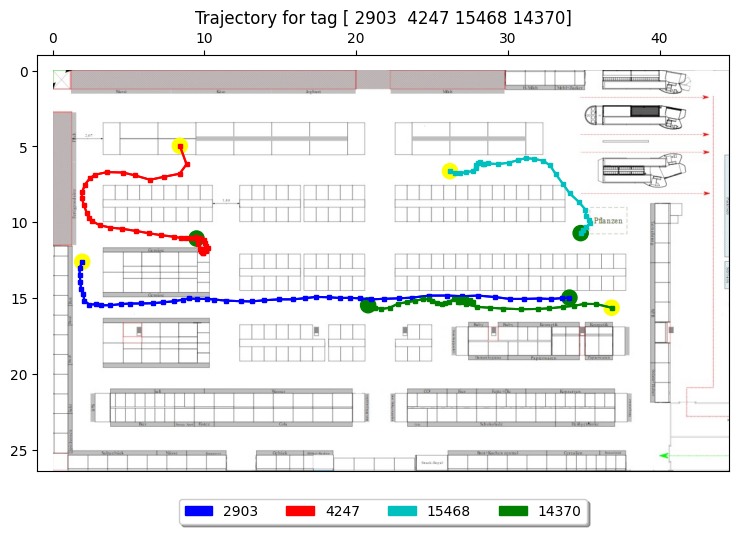

 95%|█████████▌| 19/20 [18:20<00:54, 54.14s/it]

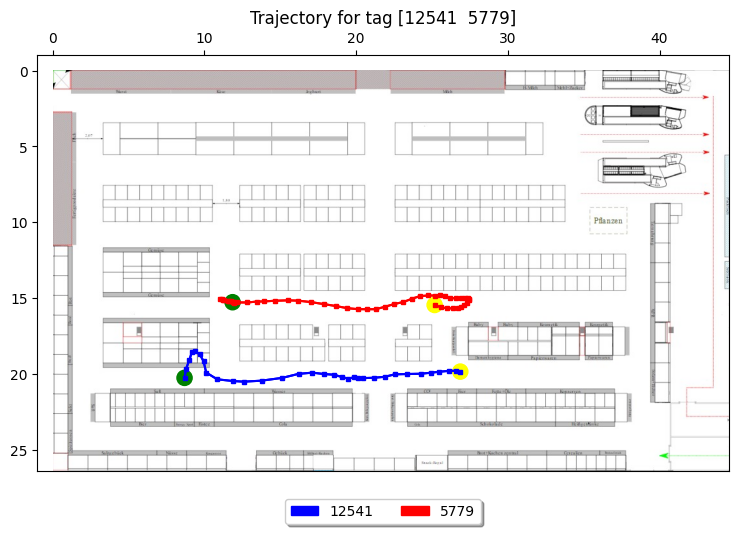

100%|██████████| 20/20 [19:05<00:00, 57.26s/it]


In [178]:
for id in tqdm(selected_trajids):
    getTrajectory(df[df.traj_id.isin(id)])
    trajectoryAnimation(df[df.traj_id.isin(id)])